In [ ]:
!pip install --upgrade pip
!pip install --upgrade keras keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 37.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.8.0
    Uninstalling keras-3.8.0:
      Successfully uninstalled keras-3.8.0


In [ ]:
!pip install --upgrade --pre keras-cv

In [ ]:
import keras
print(keras.__version__)

3.9.0


### Импортируем библиотеки

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0
from tensorflow.keras.optimizers.legacy import Adam

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128

### Набор данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2025-03-05 14:16:00--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  11.4MB/s    in 68s     

2025-03-05 14:17:10 (10.8 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
# Разархивируем датасета во временную папку 'temp'
!unzip -qo "stanford_dogs" -d ./dataset

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './dataset/'

### Отфильтруем поврежденные изображения

In [ ]:
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


### Генерируем датасет

In [ ]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.


Определим метки датасета:

In [ ]:
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

Рассмотрим несколько примеров:

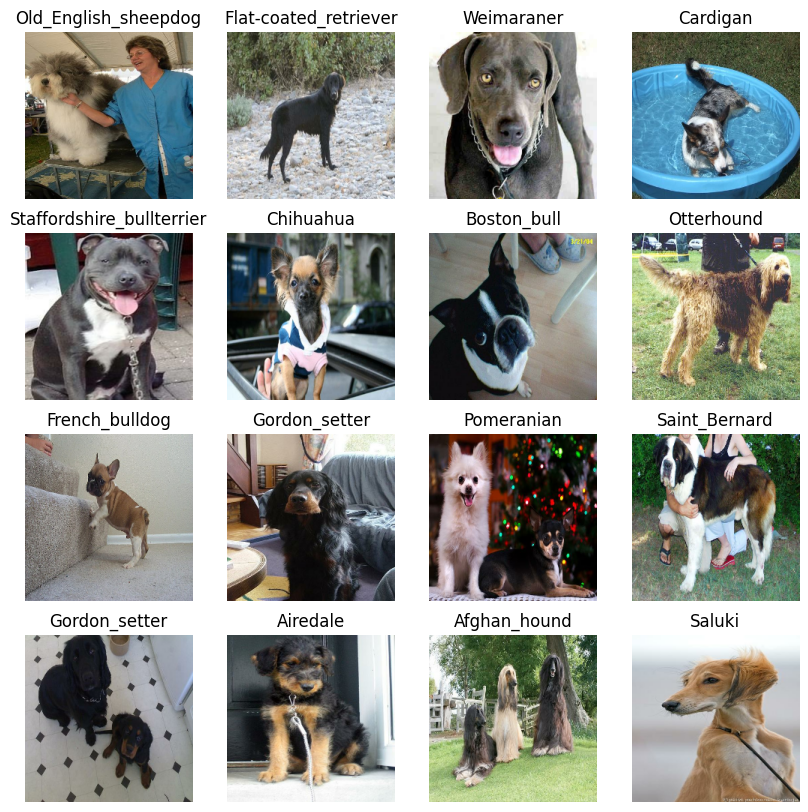

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1): # берем первый батч обучающей выборки
    for i in range(16): # отрисуем первые 16 картинок батча
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(images[i]).astype("uint8"))
        plt.title(CLASS_LIST[labels[i]]) # покажем метки
        plt.axis("off") # отключаем отображение осей

### Аугментация данных

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

Выведем 16 примеров аугментированных изображений:

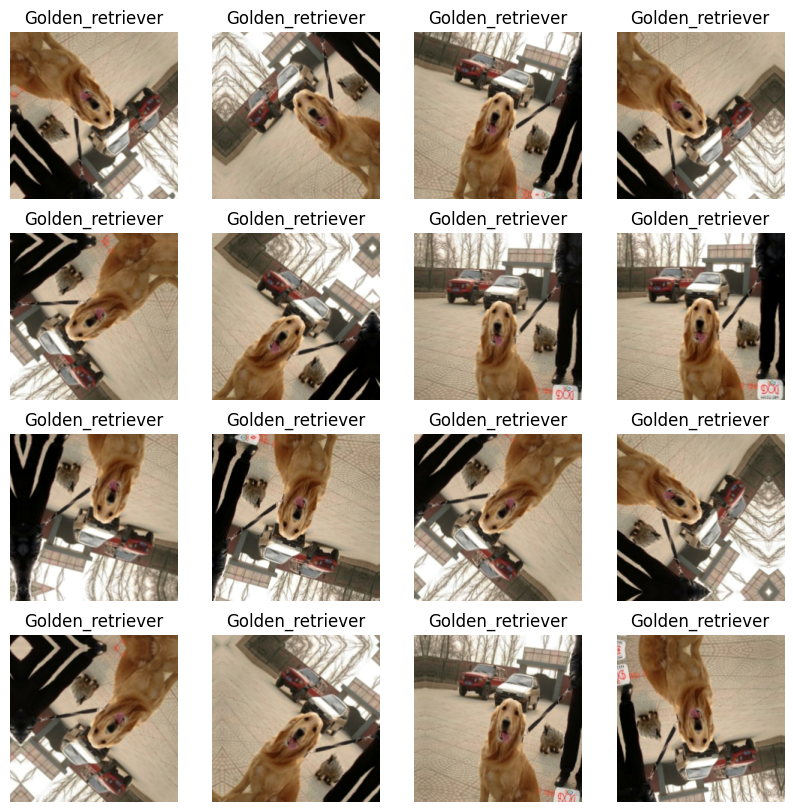

In [ ]:
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1):
    for i in range(16):
        augmented_images = img_augmentation(images[0])
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8")) # Преобразуем картинку в тензор, теперь уже без NumPy
        plt.title("{}".format(CLASS_LIST[label[0]])) # Вывод метки
        plt.axis("off")

### Предварительная обработка данных

In [ ]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

### Вспомогательная функция

In [ ]:
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

### Перенос обучения с предварительно обученных весов

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, weights="imagenet", input_tensor=inputs, input_shape=(224, 224, 3))

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNetV2")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - acc: 0.3945 - loss: 3.3025 - val_acc: 0.7825 - val_loss: 0.7791
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - acc: 0.5896 - loss: 1.6677 - val_acc: 0.8296 - val_loss: 0.5904
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - acc: 0.6381 - loss: 1.3157 - val_acc: 0.8410 - val_loss: 0.5195
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - acc: 0.6542 - loss: 1.2038 - val_acc: 0.8235 - val_loss: 0.5751
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - acc: 0.6692 - loss: 1.1655 - val_acc: 0.8435 - val_loss: 0.5136
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - acc: 0.6677 - loss: 1.1410 - val_acc: 0.8381 - val_loss: 0.5310
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - acc: 0.6826 - loss: 1.0863 - val_acc: 0.8294 - val_loss: 0.5468
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - acc: 0.6814 - loss: 1.0983 - val_acc: 0.8410 - val_loss: 0.51

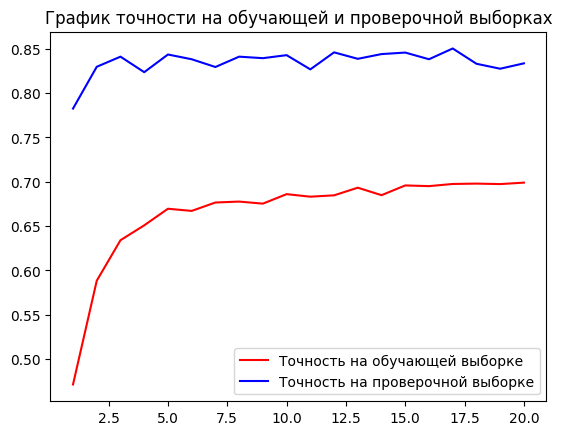

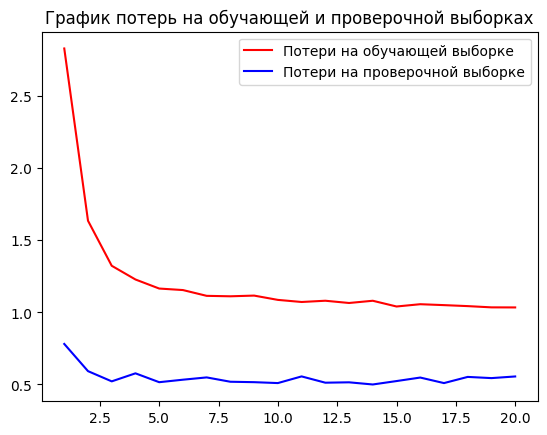

In [ ]:
show_plot(history)

In [ ]:
from google.colab import files
files.download('best_model_pretrain.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Разморозка весов

Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - acc: 0.7025 - loss: 0.9927 - val_acc: 0.8425 - val_loss: 0.5280
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - acc: 0.7213 - loss: 0.9569 - val_acc: 0.8471 - val_loss: 0.5124
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - acc: 0.7187 - loss: 0.9524 - val_acc: 0.8522 - val_loss: 0.5012
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - acc: 0.7313 - loss: 0.9155 - val_acc: 0.8537 - val_loss: 0.4930
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - acc: 0.7342 - loss: 0.9026 - val_acc: 0.8571 - val_loss: 0.4872
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - acc: 0.7261 - loss: 0.8909 - val_acc: 0.8568 - val_loss: 0.4824
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - acc: 0.7368 - loss: 0.8682 - val_acc: 0.8585 - val_loss: 0.4791
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - acc: 0.7390 - loss: 0.8782 - val_acc: 0.8602 - val_loss: 0.4772
Epoch 9/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/

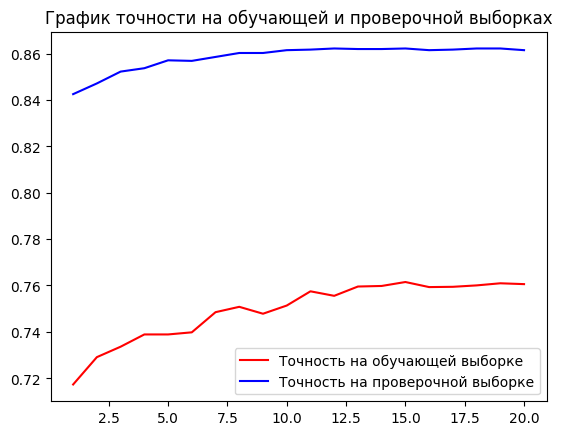

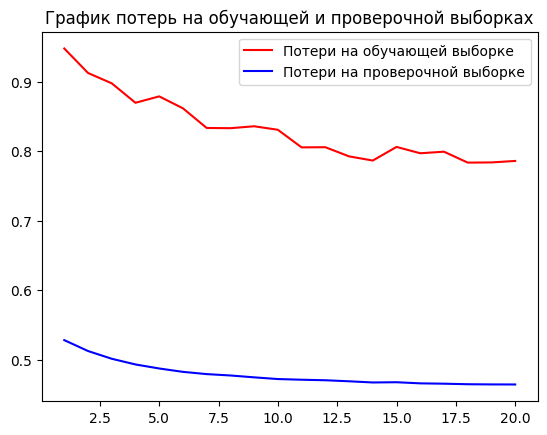

In [ ]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

epochs = 20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history)

### Проверка модели

--2025-03-05 16:56:12--  https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47310 (46K) [image/jpeg]
Saving to: ‘Cardigan.jpeg’

Cardigan.jpeg       100%[===================>]  46.20K   163KB/s    in 0.3s    

2025-03-05 16:56:14 (163 KB/s) - ‘Cardigan.jpeg’ saved [47310/47310]

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


(-0.5, 223.5, 223.5, -0.5)

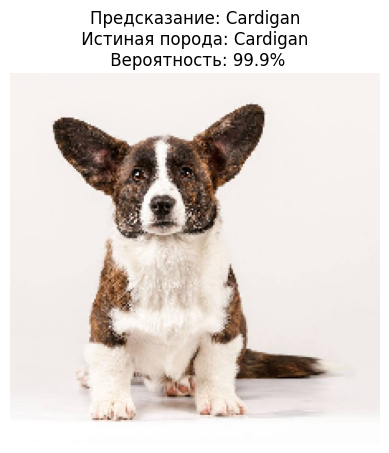

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
TEST_IMG='./Cardigan.jpeg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Cardigan \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

In [ ]:
model.save('dogs.h5')

In [ ]:
from google.colab import files
files.download('dogs.h5')